In [91]:
import torch
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import timm
# 设置随机数种子
torch.manual_seed(540446740)

# 如果你使用 GPU，还需要设置 GPU 随机数种子
torch.cuda.manual_seed(540446740)

In [92]:
root_dir = r"D:\COMP5329S1A2Dataset"
images_path = os.path.join(root_dir,'data')
labels_path = os.path.join(root_dir, 'train.csv')
df = pd.read_csv(labels_path, usecols = [0, 1])

In [93]:
df.head()

,ImageID,Labels
0,0.jpg,1
1,1.jpg,1 19
2,2.jpg,1
3,3.jpg,8 3 13
4,4.jpg,8 3 7


In [94]:
label = np.zeros((df.shape[0], 19))
for i in range(len(df['Labels'])):
  cur_label = [int(i) for i in df['Labels'][i].split(' ')]
  for j in cur_label:
    label[i, j-1] = 1

In [95]:
non_zero_rows = np.any(label, axis=0)
label = label[:, non_zero_rows]

In [96]:
counts = np.sum(label, axis = 0)
print(counts)

[22797.  1164.  4365.  1272.  1132.  1395.  1221.  2210.  1042.  1471.
   604.   605.   252.  1934.  1099.  1430.  1525.  1020.]


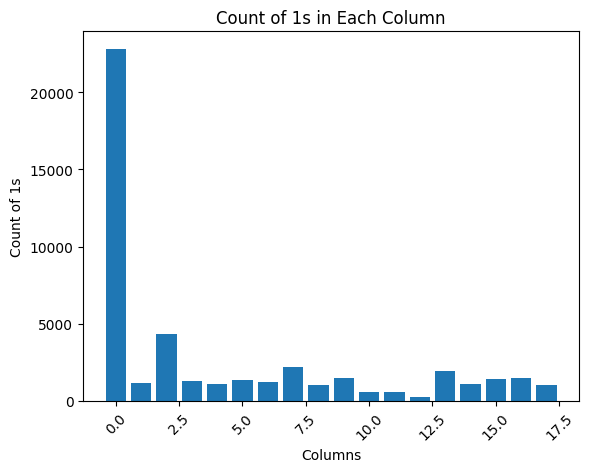

In [97]:
# Now plot all the counts together
plt.bar([i for i in range(18)], counts)
plt.title('Count of 1s in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of 1s')
plt.xticks(rotation=45)  # Rotate labels if they are long
plt.show()

In [98]:
class MultiLabelDataset(Dataset):
    def __init__(self, images_path, df, labels, transform=None):
        self.images_path = images_path
        self.df = df
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the number of items in the dataset
        return len(self.df)

    def __getitem__(self, idx):
        # Get the image name from the DataFrame
        img_name = self.df.iloc[idx, 0]
        # Construct the full path to the image
        img_path = os.path.join(self.images_path, img_name)
        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Get the labels for the current image
        labels = self.labels[idx, :].astype('float')

        # Apply any transformations
        if self.transform:
            image = self.transform(image)

        # Return the image and its labels
        return image, labels

In [99]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 256x256
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [100]:
dataset = MultiLabelDataset(images_path, df, label, transform=transform)

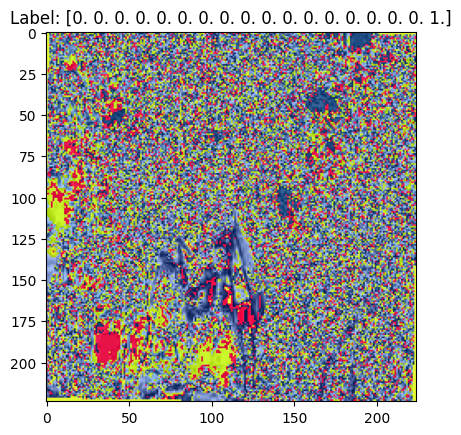

In [101]:
import torchvision.transforms.functional as F

# Assuming the image is a PyTorch tensor after transformations
image, label = dataset[54]  # Change 0 to another index to view a different image

# Convert the tensor to a PIL image for display
image = F.to_pil_image(image)

# Display the image
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()

In [110]:
from torch.utils.data import DataLoader, random_split


# Calculate the lengths
total_size = 30000
train_size = int(0.8 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [111]:
train_dataset = dataset

In [112]:
batch_size = 32 # Define the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [132]:
model = timm.create_model('vit_small_r26_s32_224', pretrained=True)
last_layer = model.head
num_features= last_layer.out_features
fc = nn.Sequential(
    last_layer,
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(num_features, 18),
)
model.head = fc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): HybridEmbed(
    (backbone): ResNetV2(
      (stem): Sequential(
        (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (norm): GroupNormAct(
          32, 64, eps=1e-05, affine=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
      )
      (stages): Sequential(
        (0): ResNetStage(
          (blocks): Sequential(
            (0): Bottleneck(
              (downsample): DownsampleConv(
                (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (norm): GroupNormAct(
                  32, 256, eps=1e-05, affine=True
                  (drop): Identity()
                  (act): Identity()
                )
              )
              (conv1): StdConv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [135]:
name = "VIT_small_32_3epoch_withnorm"

In [136]:
from torch.nn import BCEWithLogitsLoss

# Define the loss function and optimizer
loss_function = BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [137]:
num_epochs = 3
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    # Explicitly create a tqdm object for the training loader
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for images, labels in train_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > 0.5  # Applying sigmoid and thresholding to get predictions
        correct += (predicted == labels).sum().item()
        total += labels.numel()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    # Explicitly create a tqdm object for the validation loader
    valid_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1} Validation")
    with torch.no_grad():
        for images, labels in valid_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            valid_loss += loss.item()
            predicted = torch.sigmoid(outputs).data > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.numel()
    
    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(correct / total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Validation Loss: {valid_losses[-1]}, Validation Accuracy: {valid_accuracies[-1]}')

Epoch 1 Validation: 100%|██████████| 141/141 [00:16<00:00,  8.34it/s]


Epoch 1, Train Loss: 0.1443965350297898, Train Accuracy: 0.9521296296296297, Validation Loss: 0.09473946493124433, Validation Accuracy: 0.9674938271604938


Epoch 2 Validation: 100%|██████████| 141/141 [00:16<00:00,  8.39it/s]


Epoch 2, Train Loss: 0.0915066653673833, Train Accuracy: 0.9684351851851852, Validation Loss: 0.07999744536299767, Validation Accuracy: 0.9715185185185186


Epoch 3 Validation: 100%|██████████| 141/141 [00:16<00:00,  8.34it/s]

Epoch 3, Train Loss: 0.07782011776248247, Train Accuracy: 0.972875925925926, Validation Loss: 0.06493042485026687, Validation Accuracy: 0.977


In [138]:
torch.cuda.empty_cache()

In [139]:
torch.save(model.state_dict(), '{}.pth'.format(name))

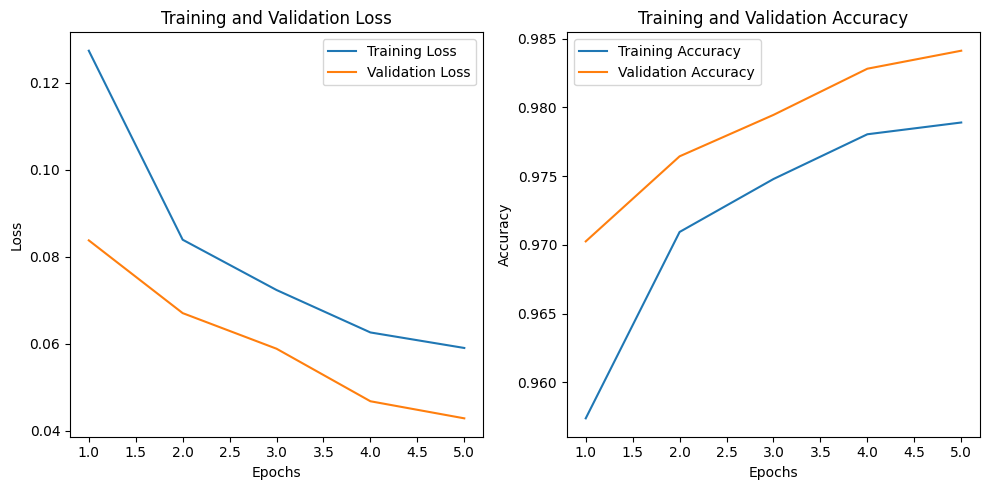

In [33]:
epochs = range(1, len(train_losses) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # No gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > 0.5  # Apply sigmoid and threshold
        correct += (predicted == labels).sum().item()
        total += labels.numel()

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

KeyboardInterrupt: 

## Predict

In [140]:
transform_predict = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 256x256
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [141]:
predict_path = os.path.join(root_dir,'predict')
predict_label_path = os.path.join(root_dir, 'test.csv')

In [142]:
label = np.zeros((df.shape[0], 19))
for i in range(len(df['Labels'])):
  cur_label = [int(i) for i in df['Labels'][i].split(' ')]
  for j in cur_label:
    label[i, j-1] = 1

In [143]:
df_predict = pd.read_csv(predict_label_path, usecols = [0, 1])
predict_set = MultiLabelDataset(predict_path, df_predict, label[:10000], transform=transform_predict)

In [144]:
len(predict_set)

10000

In [145]:
predict_loader = DataLoader(predict_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last = False)

In [146]:
predict_loader.batch_size

32

In [147]:
#验证
names = pd.read_csv(r"D:\COMP5329S1A2Dataset\test.csv", usecols = [0, 1])['ImageID']

#转测试模式
model.eval()
#不更新梯度做计算
result = []
j = 0
with torch.no_grad():
    for images, labels in predict_loader:
        images = images.to(device)      
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        predictions = probabilities.data > 0.5  # Apply sigmoid and threshold

        # 如果某一行中所有值的概率都小于0.5，则将该行的最大概率设为1
        # 遍历每一行，如果所有概率都小于0.5，则将该行最大值设为1，其他值设为0
        for i in range(predictions.size(0)):
            if torch.all(probabilities[i] < 0.5):
                max_prob_index = torch.argmax(probabilities[i])
                predictions[i] = torch.zeros_like(predictions[i])
                predictions[i, max_prob_index] = 1.0

        labels = [torch.nonzero(predictions[i]).squeeze(1) for i in range(predictions.shape[0])]
        for _ in range(len(labels)):
            result.append([names[_+j], labels[_]])
        j += batch_size

In [148]:
# 将每一行tensor转换为字符串
str_data = [str(row[1].tolist()) for row in result]

# 使用Counter统计每一行tensor作为整体的频率
total_value_counts = Counter(str_data)

print(total_value_counts)

Counter({'[0]': 5595, '[15]': 338, '[0, 13]': 291, '[0, 2]': 213, '[4]': 211, '[0, 8]': 206, '[0, 6]': 204, '[16]': 189, '[0, 17]': 176, '[14]': 172, '[0, 3]': 137, '[6]': 125, '[0, 2, 5]': 105, '[13]': 105, '[0, 5]': 96, '[8]': 93, '[0, 16]': 86, '[0, 1]': 85, '[0, 4]': 83, '[11]': 81, '[0, 2, 9]': 81, '[9]': 80, '[2]': 69, '[10]': 63, '[17]': 63, '[0, 7]': 52, '[7]': 50, '[0, 2, 7]': 50, '[0, 2, 3]': 47, '[5]': 47, '[3]': 45, '[2, 9]': 45, '[0, 14]': 35, '[1]': 30, '[0, 1, 2]': 29, '[2, 7]': 29, '[0, 15]': 28, '[2, 11]': 25, '[0, 1, 3]': 24, '[0, 2, 5, 9]': 20, '[0, 9]': 15, '[0, 2, 7, 9]': 14, '[4, 8]': 14, '[15, 16]': 14, '[0, 2, 11]': 13, '[0, 2, 13]': 13, '[0, 1, 2, 3]': 12, '[6, 9]': 12, '[12]': 12, '[2, 10]': 11, '[0, 10]': 11, '[2, 3]': 11, '[13, 16]': 11, '[0, 6, 9]': 10, '[0, 2, 10]': 10, '[2, 15]': 10, '[0, 4, 7]': 9, '[0, 4, 8]': 9, '[2, 12]': 9, '[1, 3]': 8, '[13, 15]': 8, '[0, 12]': 8, '[0, 8, 13]': 8, '[0, 2, 3, 7]': 7, '[0, 8, 14]': 7, '[13, 14]': 7, '[0, 11]': 7, '[0,

In [149]:
len(str_data)

10000

In [150]:
final_output = pd.DataFrame(result, columns = ["ImageID","Labels"])

In [151]:
for _ in range(len(result)):
    cur_name = result[_][0]
    vector = result[_][1]
    tmp = ""
    for i in range(len(vector)):
        num = vector[i].item()
        if num >= 11:
            num += 1
        tmp = tmp + str(num+1) + " "
    final_output.iloc[_, :] = [cur_name, tmp.strip()]

In [152]:
final_output.to_csv("{}.csv".format(name), index=False)